In [1]:
import os, sys
import numpy
import matplotlib.pyplot as plt
import seaborn as sns ;sns.set()

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

In [2]:
data_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-13_classify_datagen_no_dissipation"
raw_data = load_data(path=data_path,as_df=False)

Finished loading data into numpy array. Took 12.93s


In [3]:
offset = 150
shifted_data, center = get_window(raw_data,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

The Echo pulse occurs at timestep: 628


In [4]:
rescaled_dataset = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

# Polynomial Feature extraction

- Input:
    - No of equal partitions of the dataset (say 2,5,10)
    - Order of polynomial for Polynomial fit on that specific window

In [35]:
output = poly_featextract(dataset=rescaled_dataset, n_splits=[4,5,10], order_fits=[3,3,3],as_df=True)

In [36]:
output.head()

,4_1_0,4_1_1,4_1_2,4_1_3,4_2_0,4_2_1,4_2_2,4_2_3,4_3_0,4_3_1,4_3_2,4_3_3,4_4_0,4_4_1,4_4_2,4_4_3,5_1_0,5_1_1,5_1_2,5_1_3,5_2_0,5_2_1,5_2_2,5_2_3,5_3_0,5_3_1,5_3_2,5_3_3,5_4_0,5_4_1,5_4_2,5_4_3,5_5_0,5_5_1,5_5_2,5_5_3,10_1_0,10_1_1,10_1_2,10_1_3,10_2_0,10_2_1,10_2_2,10_2_3,10_3_0,10_3_1,10_3_2,10_3_3,10_4_0,10_4_1,10_4_2,10_4_3,10_5_0,10_5_1,10_5_2,10_5_3,10_6_0,10_6_1,10_6_2,10_6_3,10_7_0,10_7_1,10_7_2,10_7_3,10_8_0,10_8_1,10_8_2,10_8_3,10_9_0,10_9_1,10_9_2,10_9_3,10_10_0,10_10_1,10_10_2,10_10_3
0,6.947025e-10,-1.226582e-05,0.000156,0.038590,0.000005,0.000265,0.007218,0.153563,-0.000012,0.000335,0.001970,-0.006142,1.291351e-07,0.000008,0.000064,0.016623,-5.381390e-07,-0.000014,0.000634,0.037615,6.928431e-07,0.000069,2.671809e-03,0.063943,0.000009,-0.000883,-0.012359,0.698418,2.006999e-06,0.000024,-0.001854,0.022373,-8.440296e-07,0.000014,0.000741,0.016650,0.000008,0.000096,-0.000472,0.019608,-0.000005,0.000083,0.000144,0.033835,7.400231e-07,0.000062,0.001248,0.036047,6.933564e-07,0.000084,0.005332,0.122377,0.000008,0.000660,0.026514,0.508156,-1.786997e-05,0.001530,-0.030892,0.194834,0.000009,-0.000092,-0.002172,0.051365,-4.146666e-06,0.000046,0.001155,0.011139,-6.330972e-06,0.000035,0.000522,0.012907,-0.000011,-0.000044,0.002000,0.028879
1,4.615664e-08,1.465331e-07,0.000119,0.035902,0.000003,0.000255,0.008635,0.189759,-0.000012,0.000340,0.002255,-0.005983,3.635445e-08,0.000017,0.000701,0.019543,-9.075542e-07,-0.000004,0.000672,0.036263,1.808324e-06,0.000066,2.525304e-03,0.086303,0.000011,-0.000861,-0.014688,0.710899,1.058777e-06,0.000004,-0.001413,0.031644,-6.158128e-07,0.000019,0.001328,0.025532,0.000016,0.000157,-0.002013,0.018799,-0.000011,0.000105,0.000855,0.032091,-6.435901e-06,-0.000040,0.003089,0.060330,-1.852671e-06,0.000058,0.006548,0.150186,0.000005,0.000503,0.025308,0.559946,-1.135274e-05,0.001558,-0.031694,0.190412,0.000007,-0.000050,-0.001692,0.050129,5.363922e-06,0.000061,-0.001265,0.014794,-6.711923e-07,0.000011,0.000294,0.014864,-0.000006,-0.000060,0.002321,0.051008
2,1.853850e-07,-2.588747e-05,-0.000268,0.037118,0.000012,0.000292,-0.003466,-0.021520,-0.000012,0.000369,0.001896,-0.030654,6.197467e-07,-0.000030,-0.000696,0.049521,-8.070534e-07,-0.000039,0.000582,0.039729,9.700753e-07,0.000026,7.405212e-08,0.014025,-0.000009,-0.000877,0.005194,0.551163,-7.813369e-07,-0.000006,0.000512,0.021257,2.450520e-06,-0.000014,-0.002129,0.043323,0.000004,-0.000002,0.000310,0.023241,0.000004,0.000002,-0.002052,0.032755,-2.173274e-06,0.000078,0.000598,0.009464,7.268544e-06,0.000173,0.000500,0.015570,0.000063,0.002377,0.022501,0.092057,-2.127514e-05,0.001788,-0.030098,0.174591,-0.000002,0.000056,0.000376,0.012469,3.150262e-07,0.000007,-0.000436,0.021649,1.991557e-07,-0.000078,0.000352,0.060088,-0.000003,0.000164,-0.000326,0.011515
3,1.326682e-07,-2.481366e-05,-0.000192,0.034206,0.000008,0.000312,0.002325,0.038328,-0.000013,0.000326,0.003553,-0.006365,4.457293e-07,-0.000016,-0.000264,0.030646,-6.664334e-07,-0.000033,0.000579,0.035677,-1.170074e-06,0.000030,1.939209e-03,0.021317,0.000006,-0.000923,-0.007348,0.633165,2.170847e-06,0.000020,-0.002438,0.025313,6.183931e-07,-0.000003,-0.000578,0.027468,0.000006,0.000030,0.000051,0.018201,0.000001,0.000023,-0.001404,0.029499,-5.928648e-07,0.000040,0.000010,0.006072,3.209013e-06,-0.000060,0.001493,0.056440,0.000022,0.001214,0.029045,0.331858,3.353723e-07,0.001969,-0.033173,0.143192,0.000008,-0.000115,-0.002376,0.062359,-2.155701e-06,0.000047,0.000314,0.005380,7.299708e-07,-0.000055,-0.000151,0.035029,-0.000010,0.000002,0.001206,0.021452
4,2.271386e-08,-5.997791e-07,-0.000018,0.033192,0.000004,0.000262,0.008200,0.174777,-0.000012,0.000344,0.002174,-0.010897,-4.663572e-07,0.000012,0.001233,0.026269,-1.072161e-06,-0.000008,0.000567,0.035107,1.019645e-06,0.000062,2.780082e-03,0.077337,0.000012,-0.000871,-0.014346,0.707850,1.052819e-06,0.000001,-0.001197,0.028725,-1.990849e-06,0.000005,0.002156,0.035061,0.000016,0.000152,-0.002253,0.019325,-0.000006,0.000091,-0.000065,0.028378,-6.418528e-06

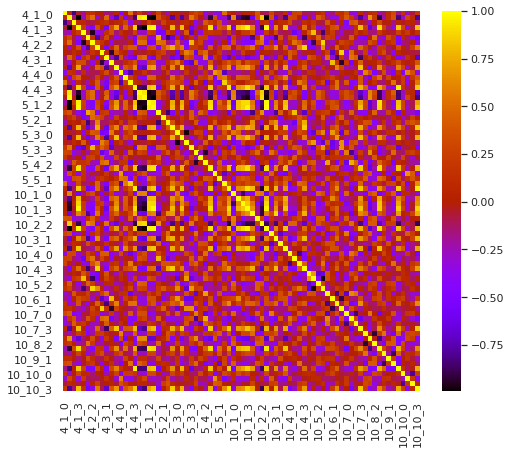

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,7))

sns.heatmap(output.corr(),cmap='gnuplot',ax=ax)
plt.show()

In [9]:
# Sort values based on Mean value
(output.describe().T).sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
5_3_4,10000.0,0.827448,0.056292,0.352465,0.803402,0.838916,0.865966,0.949331
10_5_3,10000.0,0.466837,0.123119,0.053338,0.432673,0.515258,0.544277,0.775138
10_6_3,10000.0,0.274127,0.119488,0.070889,0.172902,0.272053,0.370214,0.545808
10_4_3,10000.0,0.124621,0.071732,0.004979,0.097992,0.122684,0.136953,0.742976
5_1_4,10000.0,0.110082,0.204993,0.003754,0.018354,0.027619,0.064278,0.875291
...,...,...,...,...,...,...,...,...
5_3_2,10000.0,-0.002238,0.000325,-0.003415,-0.002427,-0.002218,-0.002022,-0.000316
10_7_2,10000.0,-0.002271,0.005175,-0.033963,-0.004613,-0.002320,0.000182,0.049612
10_2_2,10000.0,-0.003149,0.008584,-0.053504,-0.001273,-0.000055,0.000137,0.003120
5_3_3,10000.0,-0.008924,0.007307,-0.028064,-0.014151,-0.007834,-0.003845,0.011134


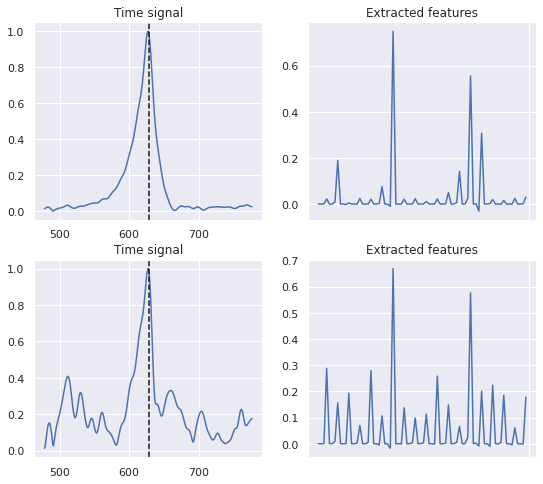

In [52]:
fig,axes = plt.subplots(2,2,figsize=(9,8))
plots = [10,100]

for i in range(2):
    axes[i,0].plot(range(center-offset,center+offset),rescaled_dataset[plots[i],:])
    axes[i,0].axvline(x=center,color='k',ls='--',label='Echo Pulse')
    axes[i,0].set_title("Time signal")
    axes[i,1].plot(output.iloc[plots[i],:])
    axes[i,1].set_xticks(" ")
    axes[i,1].set_title("Extracted features")


In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Choosign the right number of clusters

In [53]:
no_clusters = 15
Sum_of_squared_distances = np.zeros(no_clusters)

for k in range(1,no_clusters+1):
    km = KMeans(n_clusters=k,init="k-means++",verbose=True,
                n_jobs=5,algorithm='elkan')
    km = km.fit(output)
    Sum_of_squared_distances[k-1]=km.inertia_

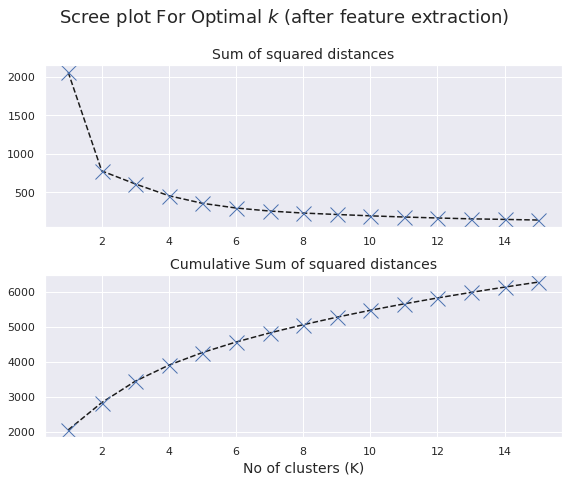

In [55]:
fig,axes = plt.subplots(2,1,figsize=(8,7))

axes[0].plot(range(1,no_clusters+1), Sum_of_squared_distances, 'k--')
axes[0].plot(range(1,no_clusters+1), Sum_of_squared_distances, 'bx',markersize=15)
axes[0].set_title('Sum of squared distances',fontsize=14)

axes[1].plot(range(1,no_clusters+1),np.cumsum(Sum_of_squared_distances),'k--')
axes[1].plot(range(1,no_clusters+1),np.cumsum(Sum_of_squared_distances),'bx',markersize=15)
axes[1].set_title('Cumulative Sum of squared distances',fontsize=14)
axes[1].set_xlabel('No of clusters (K)',fontsize=14)


#axes[0].legend(bbox_to_anchor=[1.01,0.8])
plt.suptitle('Scree plot For Optimal $k$ (after feature extraction)',fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

In [15]:
model = KMeans(n_clusters=3,n_jobs=5)
model.fit(output)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=5, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
pca_2d, pca_2d_explained_ratio = pca2D(output)

In [31]:
print(pca_2d_explained_ratio)

[0.73518641 0.10505009]


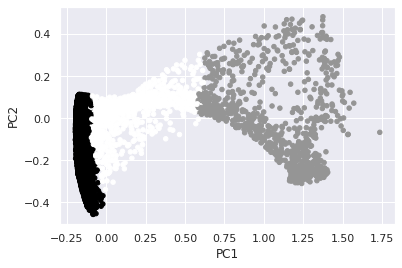

In [32]:
pca_2d.plot.scatter('PC1','PC2',c=model.labels_)